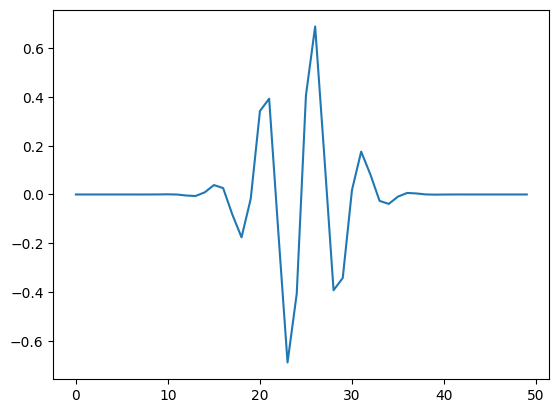

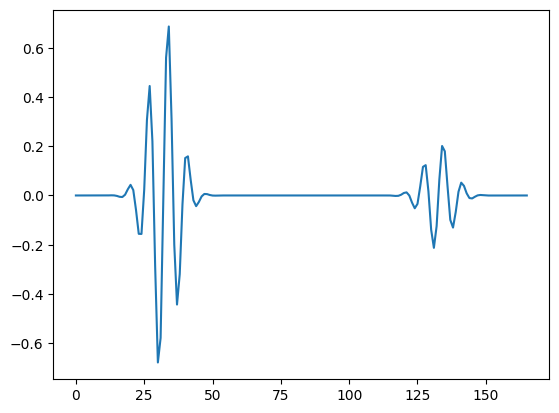

10


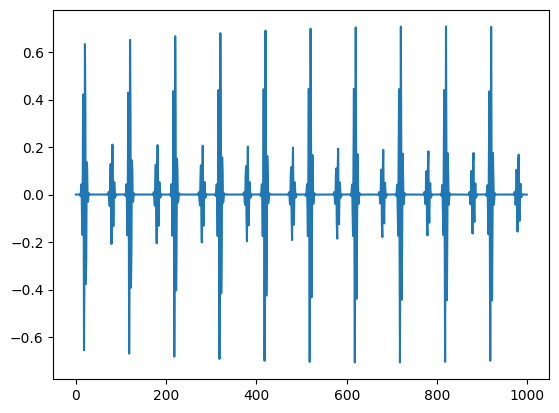

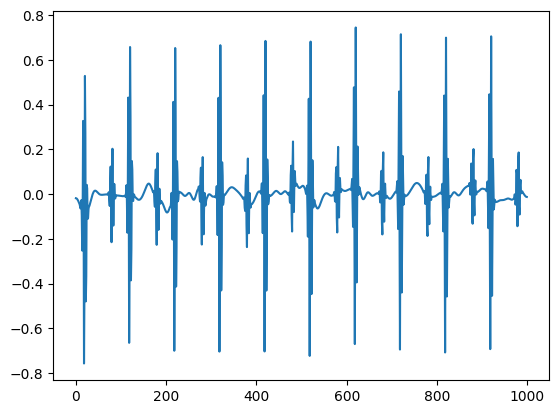

In [10]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import interp1d
import datasim as nk
import random


diastolic = 80
systolic=160


fs = 100
t = np.linspace(0, 10, 10 * fs)
sampling_rate = 100
heart_rate = 60
duration = 10
length = 1000

cardiac_length = int(100*sampling_rate/heart_rate) #sampling_rate #
# ind = random.randint(17, 34)  20 19 21 22
ind = 20
cardiac_s = scipy.signal.morlet(50,ind).imag
cardiac_d = cardiac_s*0.3*diastolic/80 # change height to 0.3
plt.plot(cardiac_s)
# plt.plot(cardiac_d)
plt.show()

peak1, mag1 = scipy.signal.find_peaks(cardiac_s)
peak2, mag2 = scipy.signal.find_peaks(cardiac_d)

# print(cardiac_s[peak1])
# print(cardiac_d[peak2])
# print(cardiac_s[peak1]/cardiac_d[peak2])
# print(0.3*diastolic/80)
# print(len(cardiac_s))
cardiac_s = scipy.signal.resample(cardiac_s, 100)
cardiac_d = scipy.signal.resample(cardiac_d, 100)

# plt.plot(cardiac_s)
# plt.plot(cardiac_d)
# plt.show()

# cardiac_s = cardiac_s[0:40]
# distance = 180-systolic # systolic 81-180
distance = random.randint(40, 140)
# distance = 80

zero_signal = np.zeros(distance)
cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])
# plt.plot(cardiac)
# plt.show()
# print(len(cardiac))
cardiac = scipy.signal.resample(cardiac, cardiac_length) # fix every cardiac length to 1000/heart_rate

plt.plot(cardiac)
plt.show()
# print(cardiac_length)

# # Caculate the number of beats in capture time period
num_heart_beats = int(duration * heart_rate / 60)
print(num_heart_beats)
# # Concatenate together the number of heart beats needed
scg = np.tile(cardiac, num_heart_beats)


# plt.plot(scg)
# plt.show()

# # Resample
scg = nk.signal_resample(
    scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
)

# peaks2 = fpeak(scg)
# print(peaks2)
# D21 = peaks2[2]-peaks2[1]
# print(D21)
# x = 600000/((D21*heart_rate)-6000) + 320
# print(x)
plt.plot(scg)
# plt.xlim(100,500)
plt.show()

noise = 0.1
random_state = None

if noise > 0:
    scg = nk.signal_distort(
        scg,
        sampling_rate=sampling_rate,
        noise_amplitude=noise,
        noise_frequency=[5, 10, 100],
        noise_shape="laplace",
        random_state=random_state,
        silent=True,
    )

plt.plot(scg)
# plt.xlim(100,500)
plt.show()


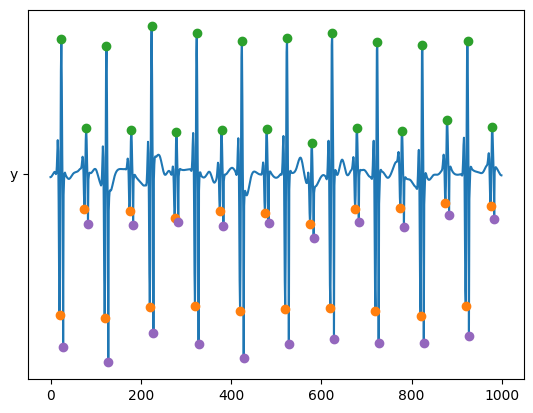

In [9]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks
from scipy.interpolate import interp1d
import datasim as nk
import random

def fpeak(signal):
    signal2 = signal
    t = np.linspace(0, 10, 10 * 100)
    # 峰值检测
    peak_indices, _ = find_peaks(signal2)  # 返回极大值点的索引

    # 线性插值
    t_peaks = t[peak_indices]  # 极大值点的时间
    peak_values = signal2[peak_indices]  # 极大值点的幅值
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)
    peaks2,_ = find_peaks(envelope)
    
    return peaks2

def scg_simulate2(
    duration=10, length=None, sampling_rate=100, noise=0.1, heart_rate=60, heart_rate_std=1, respiratory_rate=15, systolic=120,
    diastolic=80, random_state = None):

    length = 1000

    cardiac_length = int(100*sampling_rate/heart_rate) #sampling_rate #
    ind = random.randint(19, 22)
    cardiac_s = scipy.signal.morlet(50,ind).imag
    cardiac_d = cardiac_s*0.3*diastolic/80 # change height to 0.3

    cardiac_s = scipy.signal.resample(cardiac_s, 100)
    cardiac_d = scipy.signal.resample(cardiac_d, 100)

    distance = random.randint(0, 80)
    zero_signal = np.zeros(distance)
    cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])
    # plt.plot(cardiac)
    # plt.show()

    cardiac = scipy.signal.resample(cardiac, cardiac_length) # fix every cardiac length to 1000/heart_rate

    # plt.plot(cardiac)
    # plt.show()
    # print(cardiac_length)

    # # Caculate the number of beats in capture time period
    num_heart_beats = int(duration * heart_rate / 60)

    # # Concatenate together the number of heart beats needed
    scg = np.tile(cardiac, num_heart_beats)

    # plt.plot(scg)
    # plt.show()

    # # Resample
    scg = nk.signal_resample(
        scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
    )

    peaks_j = fpeak(scg)
    peaks_i = []
    peaks_k = []
    
    delete_index = []
    
    
    for m in range(len(peaks_j)):
        if scg[peaks_j[m]] < 0.1:
            delete_index = np.append(delete_index, m)

    if len(delete_index) != 0:
        delete_index = delete_index.astype(int)
    peaks_j = np.delete(peaks_j,delete_index)

    
    scg_inv = -1 * scg
    peaks_tmp,_ = find_peaks(scg_inv)
    
#     plt.plot(scg_inv)
#     plt.xlim(0,100)
#     plt.show()

    
    for j in range(len(peaks_j)):
        for k in range(len(peaks_tmp)-1):
#             print(peaks_tmp[k])
            if peaks_tmp[k] < peaks_j[j] and peaks_tmp[k + 1] > peaks_j[j]:
                peaks_i = np.append(peaks_i, peaks_tmp[k])
                peaks_k = np.append(peaks_k, peaks_tmp[k+1])
                
    peaks_i = peaks_i.astype(int)
    peaks_j = peaks_j.astype(int)
    peaks_k = peaks_k.astype(int)
    
    for o in range(len(peaks_j)):
        amp_j = scg[peaks_j[o]]
        amp_i = scg[peaks_i[o]]
#         amp_k = scg[peaks_k[o]]
#         JK - IJ)/IJ
        IJ = amp_j - amp_i
        JK = systolic / 80 * IJ
        amp_k = amp_j - JK
        scg[peaks_k[o]] = amp_k


    if noise > 0:
        scg = nk.signal_distort(
            scg,
            sampling_rate=sampling_rate,
            noise_amplitude=noise,
            noise_frequency=[5, 10, 100],
            noise_shape="laplace",
            random_state=random_state,
            silent=True,
        )
    
    
    
    return scg, peaks_i, peaks_j, peaks_k

scg, peaks_i, peaks_j, peaks_k = scg_simulate2(systolic=90)

# print(peaks_k)
plt.plot(scg)
plt.plot(peaks_i,scg[peaks_i],'o')
plt.plot(peaks_j,scg[peaks_j],'o','y')
plt.plot(peaks_k,scg[peaks_k],'o')
# plt.xlim(0,100)
plt.show()

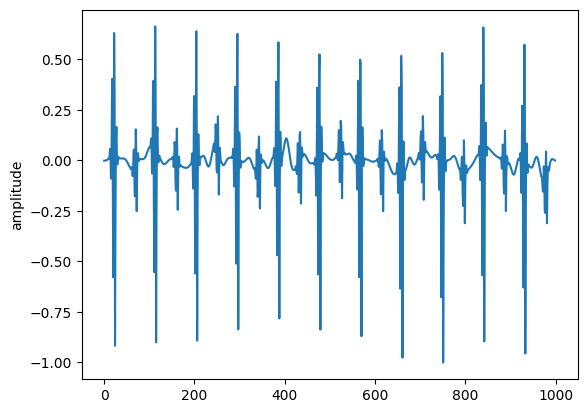

In [10]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load("../data/BPD_S_90_110.npy")
signal = data[99,:1000]
plt.plot(signal)
# plt.xlim(0,100)
plt.ylabel("amplitude")
plt.show()